#Getting the data from Kaggle

In [ ]:
!pip install kaggle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle competitions download -c isic-2024-challenge

!unzip -q isic-2024-challenge.zip

 99% 1.99G/2.00G [00:11<00:00, 205MB/s]
100% 2.00G/2.00G [00:11<00:00, 181MB/s]


Logisitic regression


In [17]:
#!mkdir -p /content/isic-2024-challenge
#!mv /content/sample_data /content/isic-2024-challenge
#!mv /content/train-metadata.csv /content/isic-2024-challenge
#!mv /content/train-image.hdf5 /content/isic-2024-challenge
#!mv /content/test-metadata.csv /content/isic-2024-challenge
#!mv /content/test-image.hdf5 /content/isic-2024-challenge
#!mv /content/isic-2024-challenge.zip /content/isic-2024-challenge
#!mv sample_submission.csv isic-2024-challenge
#!mv train-image isic-2024-challenge/
!ls /content


drive  isic-2024-challenge


In [18]:
!ls /content/isic-2024-challenge/

anscombe.json		      mnist_test.csv	     test-image.hdf5	train-metadata.csv
california_housing_test.csv   mnist_train_small.csv  test-metadata.csv
california_housing_train.csv  README.md		     train-image
isic-2024-challenge.zip       sample_submission.csv  train-image.hdf5


#Logisitic Regression Model

In [19]:
import h5py
import pandas as pd
import numpy as np
from PIL import Image
import io
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

metadata_path = '/content/isic-2024-challenge/train-metadata.csv'
metadata = pd.read_csv(metadata_path, low_memory=False)

In [20]:
target_0 = metadata[metadata['target'] == 0].sample(n=10000, random_state=42)
target_1 = metadata[metadata['target'] == 1].sample(n=393, random_state=42)
balanced_metadata = pd.concat([target_0, target_1]).reset_index(drop=True)

train_metadata, val_metadata = train_test_split(balanced_metadata, test_size=0.2, random_state=42)

In [21]:
def load_and_flatten_images(metadata, hdf5_path):
    with h5py.File(hdf5_path, 'r') as hdf5_file:
        features = []
        labels = []
        for i, row in metadata.iterrows():
            isic_id = row['isic_id']
            label = row['target']
            image = Image.open(io.BytesIO(hdf5_file[isic_id][()]))
            image = image.resize((64, 64))  # Reduce image size to 64x64 to speed up processing
            image_flat = np.array(image).flatten()  # Flatten the image
            features.append(image_flat)
            labels.append(label)
    return np.array(features), np.array(labels)

train_image_path = '/content/isic-2024-challenge/train-image.hdf5'
X_train, y_train = load_and_flatten_images(train_metadata, train_image_path)
X_val, y_val = load_and_flatten_images(val_metadata, train_image_path)

print("Training Features Shape:", X_train.shape)
print("Training Labels Shape:", y_train.shape)
print("Validation Features Shape:", X_val.shape)
print("Validation Labels Shape:", y_val.shape)

Training Features Shape: (8314, 12288)
Training Labels Shape: (8314,)
Validation Features Shape: (2079, 12288)
Validation Labels Shape: (2079,)


In [22]:
#Standardizing Data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [23]:
#Training Logistic Regression Model
logistic_regression_model = LogisticRegression(max_iter=1000)
logistic_regression_model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

In [24]:
#Model Eval
y_pred = logistic_regression_model.predict(X_val)
print("Classification Report:")
print(classification_report(y_val, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1991
           1       0.31      0.20      0.25        88

    accuracy                           0.95      2079
   macro avg       0.64      0.59      0.61      2079
weighted avg       0.94      0.95      0.94      2079



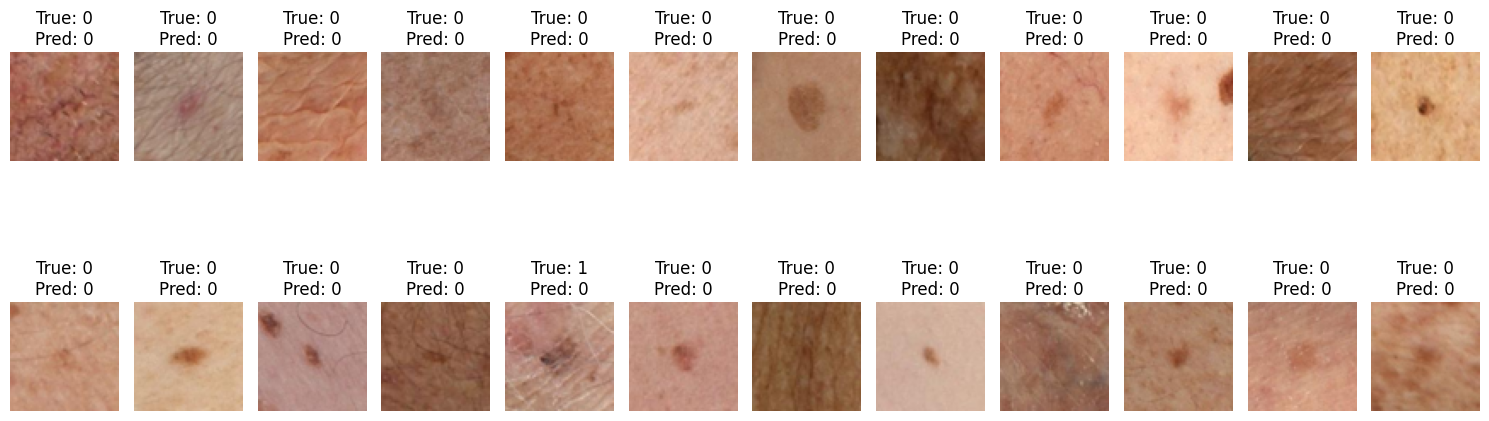

In [33]:
def plot_sample_images(metadata, hdf5_path, y_true, y_pred, num_images=10):
  with h5py.File(hdf5_path, 'r') as hdf5_file:
    fig, axes = plt.subplots(2, num_images // 2, figsize=(15, 6))
    axes = axes.flatten()
    indices = np.random.choice(len(metadata), num_images, replace=False)
    for idx, ax in zip(indices, axes):
      isic_id = metadata.iloc[idx]['isic_id']
      image = Image.open(io.BytesIO(hdf5_file[isic_id][()]))
      image = image.resize((64, 64))
      ax.imshow(image)
      ax.set_title(f'True: {y_true[idx]}\nPred: {y_pred[idx]}')
      ax.axis('off')
    plt.tight_layout()
    plt.show()

# Plot predictions for some validation images
plot_sample_images(val_metadata, train_image_path, y_val, y_pred, num_images=25)